In [1]:
import networkx as nx

from regraph import Rule, plot_rule
from regraph.neo4j.graphs import Neo4jGraph
from regraph.neo4j.cypher_utils import *

In [2]:
g = Neo4jGraph("bolt://localhost:7687", "neo4j", "admin")

In [3]:
res = g.clear()

In [4]:
nodes = ["a", "b", "c", "d", "e", "f"]
edges = [("a", "b"), ("d", "b"), ("a", "c"), ("e", "a"), ("f", "d")]
g.add_nodes_from(nodes)
g.add_edges_from(edges)

In [5]:
g.add_node("x")

In [6]:
g.add_edge("x", "c")

In [7]:
g.remove_edge("x", "c")

In [8]:
g.nodes()

['d', 'x', 'f', 'e', 'a', 'b', 'c']

In [9]:
g.edges()

[('f', 'd'), ('e', 'a'), ('d', 'b'), ('a', 'b'), ('a', 'c')]

In [10]:
res_clone_1 = g.clone_node('a')
print("Created clone by the name: ", res_clone_1)

Created clone by the name:  a1


In [11]:
res_clone_2 = g.clone_node('a', 'a_clone')
print("Created clone by the name: ", res_clone_2)

Created clone by the name:  a_clone


In [12]:
res_merge = g.merge_nodes(["a", "b"])

In [13]:
res_merge

'a_b'

In [14]:
pattern = nx.DiGraph()
pattern.add_nodes_from(["x", "y", "z", "a"])
pattern.add_edges_from([("x", "y"), ("y", "z"), ("z", "z"), ("z", "a")])

In [15]:
instances = g.find_matching(pattern)
print("Instances: ", instances)

Instances:  [{'x': 'e', 'y': 'a1', 'z': 'a_b', 'a': 'c'}, {'x': 'e', 'y': 'a_clone', 'z': 'a_b', 'a': 'c'}, {'x': 'f', 'y': 'd', 'z': 'a_b', 'a': 'c'}]


In [16]:
rule = Rule.from_transform(pattern)
clone_name, _ = rule.inject_clone_node("y")
clone_name, _ = rule.inject_clone_node("y")
rule.inject_remove_edge(clone_name, "z")
rule.inject_remove_node("x")
rule.inject_merge_nodes(["y", "a"])
rule.inject_add_node("new_node")
rule.inject_add_edge("new_node", "z")

/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


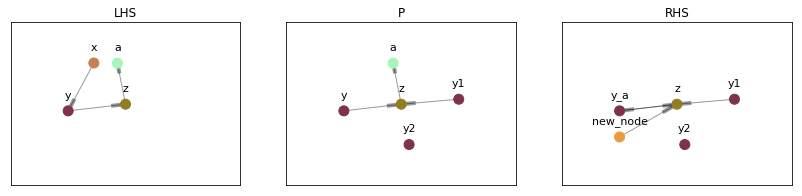

In [17]:
plot_rule(rule)

In [18]:
instances[0]

{'a': 'c', 'x': 'e', 'y': 'a1', 'z': 'a_b'}

In [19]:
rhs_g = g.rewrite(rule, instances[0])
print("\n\nRewriting rule to commands: \n")
print(rule.to_commands())

MATCH (x:node { id : 'e'}), (y:node { id : 'a1'}), (z:node { id : 'a_b'}), (a:node { id : 'c'}) , (x)-[x_y:edge]->(y), (y)-[y_z:edge]->(z), (z)-[z_z:edge]->(z), (z)-[z_a:edge]->(a) OPTIONAL MATCH (same_id_node:node) WHERE same_id_node.id = 'y1' FOREACH(new_count IN CASE WHEN same_id_node IS NOT NULL THEN [coalesce(same_id_node.count, 0) + 1] ELSE [] END | SET same_id_node.count=coalesce(same_id_node.count, 0) + 1 ) WITH same_id_node , a, x, y, z UNWIND CASE WHEN same_id_node IS NOT NULL THEN ['y1' + same_id_node.count] ELSE ['y1'] END AS y1_clone_id CREATE (y1:node { id : y1_clone_id }) WITH y, x, y1_clone_id, y1, a, z OPTIONAL MATCH (y)-[:edge]->(m:node), (o:node)-[:edge]->(y) WITH COLLECT(m) AS ms, COLLECT(o) AS os, y, x, y1_clone_id, y1, a, z FOREACH(o IN os | FOREACH(p IN CASE WHEN NOT o.id IN [] THEN [o] ELSE [] END | CREATE UNIQUE (p)-[:edge]->(y1) )) FOREACH(m IN ms | FOREACH(p IN CASE WHEN NOT m.id IN [] THEN [m] ELSE [] END | CREATE UNIQUE (y1)-[:edge]->(m) )) WITH y, x, y1_cl

In [20]:
rhs_g

{'new_node': 'new_node', 'y1': 'y1', 'y2': 'y2', 'y_a': 'a1_c', 'z': 'a_b'}